### take the output of the isochrone age fitting and see what here is to see.

Sep 3, 2023



In [94]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import time
import timeit


from astropy.io import fits as fits

from astropy.table import Table,vstack, hstack,Column
from astropy.io import ascii
from astropy.io.votable import parse_single_table


from matplotlib.colors import LogNorm, PowerNorm
from scipy.stats import binned_statistic_2d
import scipy.stats as stats

import astropy.table as at
from astropy.coordinates import SkyCoord
from astropy import units as u

from pyia import GaiaData

# Set up matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import sys

from matplotlib.ticker import FuncFormatter, MaxNLocator
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

In [2]:
workdir = '/Users/rix/Science/Projects/GAIA/GaiaDR3/BP-RP/LMC/'

In [3]:
age_fitting_output = 'age_fitting.Sep3.2023.v1.fits'
result = at.Table.read(workdir+age_fitting_output)

In [4]:
print(result.columns)

<TableColumns names=('source_id','TEFF','LOGG','FE_H','G','BP','RP','J','H','K','chi2obs','fitMH','fitlogAge','fitMini','fitAv','varMH','varlogAge','varMini','varAv','MH','logAge','Mini','Av','Dchi2_corr','index','Teff','logg','Gmag','G_BPmag','G_RPmag','Jmag','Hmag','Ksmag')>


Given vestages of the original isochrone age grid, "fuzz-out" the ages, and create a new column 'fuzzlogAge'; it makes for better plots.

In [5]:
result['fuzzlogAge'] = result['fitlogAge']+np.random.normal(0, 0.1, len(result['fitlogAge']))

Now make some minimal quality cuts. Results cannot be trusted 
* unless $3500K<Teff<4900K$
* varlogAge < 0.3

In [6]:
clean = result[ (result['TEFF']<4900) * (result['TEFF']>3500)  * (result['varlogAge']<0.3) ]

In [7]:
print(len(clean))

556570


Make a first plot: the age metallicity relation

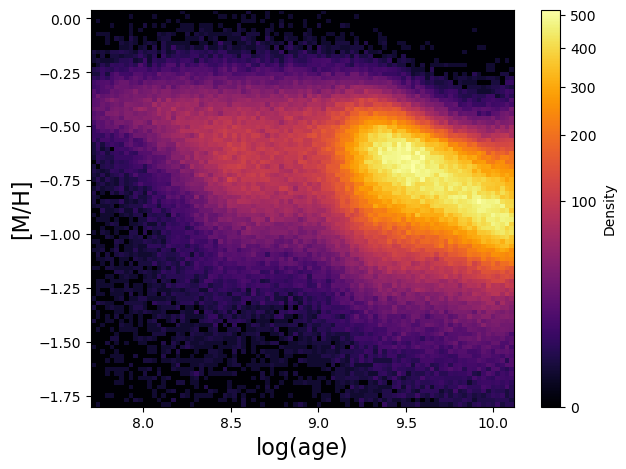

<Figure size 640x480 with 0 Axes>

In [33]:
plt.hist2d(clean['fuzzlogAge'],clean['FE_H'], bins = 90, 
           range = ((7.7,10.12), (-1.8,0.04)),cmap='inferno',norm = PowerNorm(gamma=0.4)) #LogNorm())
plt.xlabel('log(age)',size=16)
plt.ylabel('[M/H]',size=16)
plt.colorbar(label='Density')
#plt.title("%.1f" % MHmin+' < [M/H] < '+"%.1f" % MHmax+'    BP < '+"%.1f" % BPmax, size=18)

#fig = plt.gcf()
#fig.set_size_inches(8,4)
#plt.savefig(workdir+'allsky'+"%.1f" % MHmin+'_'+"%.1f" % MHmax+'_'+"%.1f" % BPmax+'.pdf')
#plt.show()

plt.show()
plt.clf()

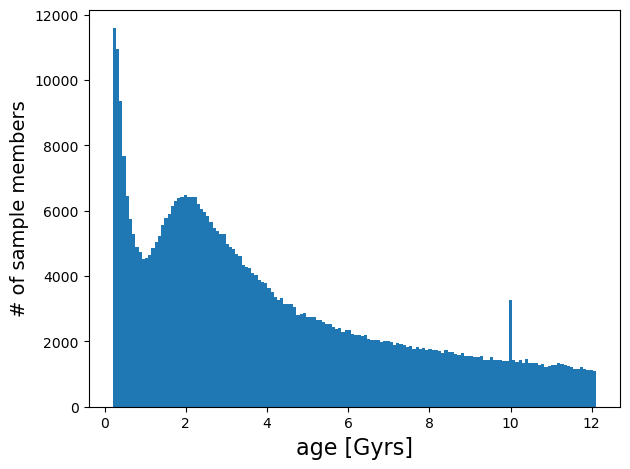

In [72]:
plt.hist(10**clean['fuzzlogAge']/1.e9,bins=150,range=(0.2,12.1))
plt.xlabel('age [Gyrs]',size=16)
plt.ylabel('# of sample members',size=14)
plt.show()

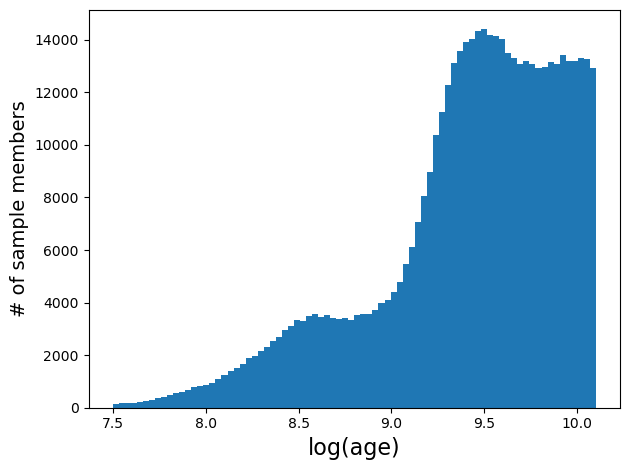

In [73]:
plt.hist(clean['fuzzlogAge'],bins=80,range=(7.5,10.1))
plt.xlabel('log(age)',size=16)
plt.ylabel('# of sample members',size=14)
plt.show()

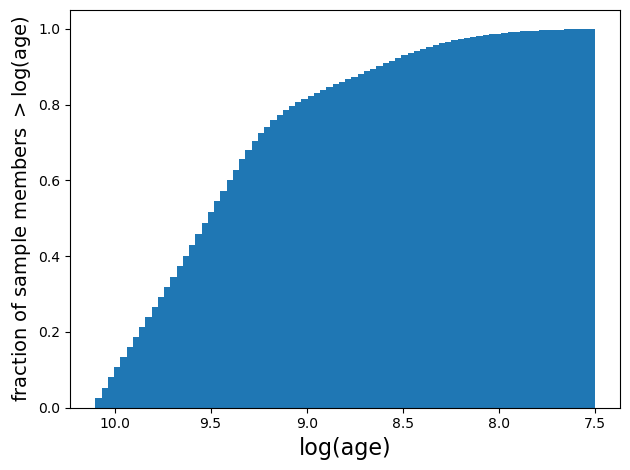

In [65]:
plt.hist(clean['fuzzlogAge'],bins=80,range=(7.5,10.1),cumulative=-1,density=True)
plt.gca().invert_xaxis()
plt.xlabel('log(age)',size=16)
plt.ylabel('fraction of sample members $>$log(age)',size=14)
plt.show()

Now match these with the basic Gaia information

In [74]:
#from astropy.io import fits
#from astroquery.gaia import Gaia

# Convert the source IDs to a list
#source_ids_list = list(clean['source_id'][1:50000])

# Prepare the query
#query = f"SELECT * FROM gaiaedr3.gaia_source WHERE source_id IN ({','.join(map(str, source_ids_list))})"

# Run the query
#job = Gaia.launch_job_async(query)
#query_result = job.get_results()

# Print the result
#print(query_result[1])

In [90]:
gaia = at.Table.read(workdir+'Gaia_Data_for_Sample.fits')
clean = at.join(clean,gaia, keys='source_id')
print(clean[3])

     source_id             TEFF        LOGG   FE_H      G         BP         RP      J      H     K    chi2obs        fitMH            fitlogAge          fitMini              fitAv               varMH              varlogAge            varMini              varAv           MH   logAge     Mini      Av     Dchi2_corr      index         Teff        logg         Gmag              G_BPmag             G_RPmag           Jmag         Hmag        Ksmag         fuzzlogAge            ra               dec               parallax       parallax_error        pmra        pmra_error        pmdec        pmdec_error    ruwe   phot_bp_rp_excess_factor         l                  b         
                                                                                                                                                                                                                                                                                                                                   

Let's now calculate the distance -- on sky -- of each source from the LMC center, and add this as a column

In [145]:
# the presumed center of the LMC is 
l_c,b_c = 280.4652,-32.8884
galactic_coord = SkyCoord(l=l_c*u.degree, b=b_c*u.degree, frame='galactic')

# Convert to Equatorial (ICRS) coordinates
equatorial_coord = galactic_coord.transform_to('icrs')

ra_c = equatorial_coord.ra.degree  # Right Ascension in degrees
dec_c = equatorial_coord.dec.degree  # Declination in degrees


In [146]:
# Create SkyCoord objects for the data and the center point
data_coords = SkyCoord(ra=clean['ra'], dec=clean['dec'], frame='icrs')
center_coord = SkyCoord(ra=ra_c*u.degree, dec=dec_c*u.degree, frame='icrs')


# Calculate the angular separation
angular_distance = center_coord.separation(data_coords)
# Add the angular separation as a new column to the table
clean['Rproj'] = Column(angular_distance.deg, name='Rproj')

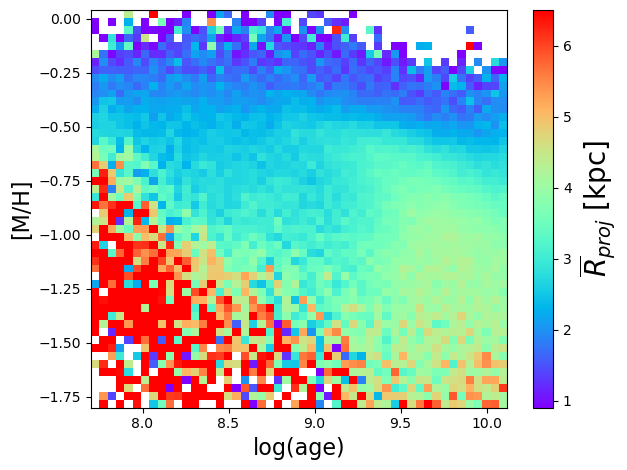

<Figure size 640x480 with 0 Axes>

In [163]:
# Binning configuration
x_bins = np.linspace(7.7, 10.12, 51)  # 90 bins
y_bins = np.linspace(-1.8, 0.04, 51)  # 90 bins

# Calculate the median value of clean['Rproj'] in each bin
statistic, x_edge, y_edge, binnumber = binned_statistic_2d(
    clean['fuzzlogAge'], clean['FE_H'], values=clean['Rproj'], 
    statistic='mean', bins=[x_bins, y_bins])

# Plotting
plt.figure()
plt.pcolormesh(x_edge, y_edge, statistic.T, cmap='rainbow',vmin=0.9,vmax=6.5)
plt.xlabel('log(age)', size=16)
plt.ylabel('[M/H]', size=16)
# Create the colorbar
cbar = plt.colorbar(label='$\overline{R}_{proj}$')
cbar.set_label('$\overline{R}_{proj}$ [kpc]', size=20)

plt.show()
plt.clf()

### make monoage maps

290


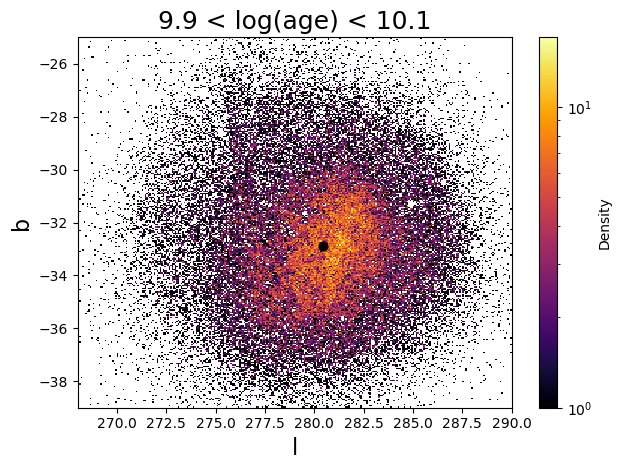

<Figure size 640x480 with 0 Axes>

In [199]:
#age selection
logAgemin,logAgemax = 9.9,10.1
mask = ( (clean['fitlogAge']>logAgemin) * (clean['fitlogAge']<logAgemax) )
# Count the number of True elements in the mask
igrid = min(max(int( 1 * np.sqrt(np.sum(mask))),50),400)
print(igrid)

plt.hist2d(clean['l'][mask],clean['b'][mask], bins = igrid, 
           range = ((268,290), (-39,-25)),cmap='inferno',norm = LogNorm())
plt.colorbar(label='Density')
# mark the center
plt.scatter(l_c, b_c, s=40, c='black')
plt.xlabel('l',size=16)
plt.ylabel('b',size=16)

plt.title("%.1f" % logAgemin+' < log(age) < '+"%.1f" % logAgemax, size=18)

#fig = plt.gcf()
#fig.set_size_inches(8,4)
plt.savefig(workdir+'LMC_mono_age_map'+"%.1f" % logAgemin+'_'+"%.1f" % logAgemax+'.png')
#plt.show()

plt.show()
plt.clf()

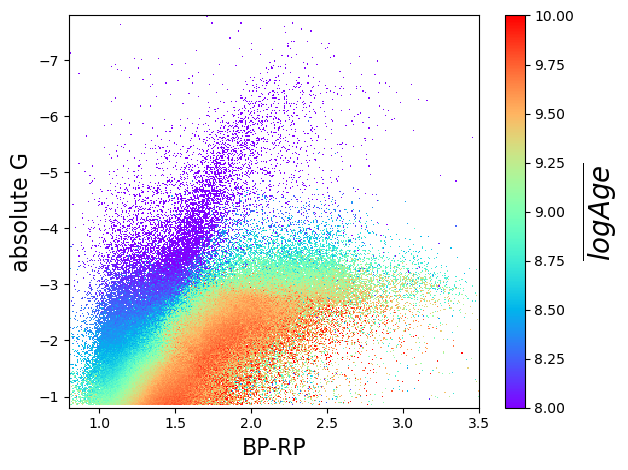

<Figure size 640x480 with 0 Axes>

In [184]:
# eliminate the oldest stars
mask = (clean['fitlogAge']<10.1) 

# Binning configuration
x_bins = np.linspace(0.8,3.5,341)  # 90 bins
y_bins = np.linspace(-7.8, -0.8, 341)  # 90 bins

# Calculate the median value of clean['Rproj'] in each bin
statistic, x_edge, y_edge, binnumber = binned_statistic_2d(
    clean['BP'][mask]-clean['RP'][mask], clean['G'][mask], values=clean['fitlogAge'][mask], 
    statistic='mean', bins=[x_bins, y_bins])

# Plotting
plt.figure()
plt.pcolormesh(x_edge, y_edge, statistic.T, cmap='rainbow',vmin=8.,vmax=10.)
plt.xlabel('BP-RP', size=16)
plt.ylabel('absolute G', size=16)
plt.gca().invert_yaxis()
# Create the colorbar
cbar = plt.colorbar(label='$\overline{logAge}$')
cbar.set_label('$\overline{logAge}$', size=20)

plt.show()
plt.clf()

But there is something funny about the ages logAge> 10.1

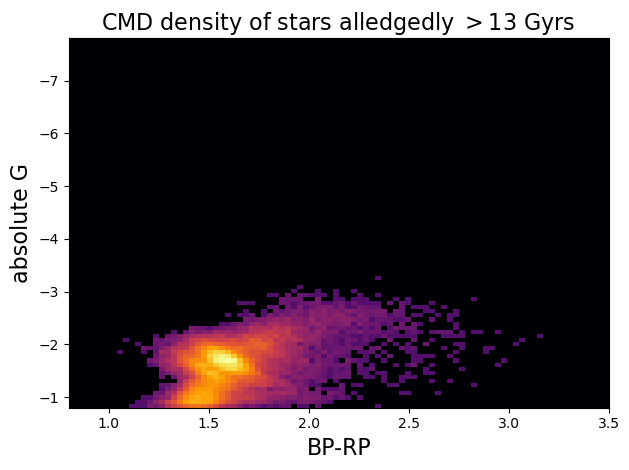

In [193]:
mask = (clean['fitlogAge']>10.1)

plt.hist2d(clean['BP'][mask]-clean['RP'][mask], clean['G'][mask], bins = 90, 
           range = ((0.8,3.5), (-7.8, -0.8)),cmap='inferno',norm = PowerNorm(gamma=0.2)) #LogNorm())
plt.xlabel('BP-RP', size=16)
plt.ylabel('absolute G', size=16)

plt.title('CMD density of stars alledgedly $> 13$ Gyrs ', size=16)

plt.gca().invert_yaxis()
plt.show()